In [1]:
from pathlib import Path
from rdkit import Chem
from iotbx.data_manager import DataManager
import numpy as np
import sys
from tqdm.notebook import tqdm
sys.path.append("..")

from phenixml.fragmentation.fragments import MolContainer, Fragment
from phenixml.fragmentation.fragmenters import MoleculeFragmenter, BondFragmenter, AngleFragmenter
from phenixml.featurizers.fragments.fingerprints import MorganFeaturizer, RDKFingerprint
from phenixml.labelers.fragment_labelers import BondFragmentLabeler, AngleFragmentLabeler

from phenixml.fragments.nn_fragments import FragmentKNN
from phenixml.fragmentation.display import FragmentDisplay
display = FragmentDisplay()

In [2]:
# get molecules
mol_dir = "/dev/shm/cschlick/geostd_passed/"
containers = MolContainer.from_folder(mol_dir,max_files=None)

## NN Recall

In [3]:
# Fragment the molecules
fragmenter = MoleculeFragmenter()
fragments = fragmenter(containers)

In [4]:
container = containers[0]
frag_indices = Chem.GetMolFrags(container.rdkit_mol, asMols=False,sanitizeFrags=False)
fragments = [Fragment(container,atom_selection=inds) for inds in frag_indices]

In [5]:
# Featurize the fragments
featurizer = MorganFeaturizer()
features = featurizer.featurize(fragments,nproc=16)

  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# Generate a new query molecule
query_container = MolContainer.from_smiles("CC1(C=C(C(N1[O])(C)C)CSS(=O)(=O)C)C")
query_fragment = query_container.full_fragment
display(query_fragment,show3d=True)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [7]:
# Get a query feature
query_feature = featurizer(query_container)

In [8]:
fragments

In [9]:
%%time
# Set up approximate kNN
knn = FragmentKNN(fragments,features)

ValueError: No hyperplanes of adequate size were found!

In [9]:
# query
nbrs = knn.query(query_feature)

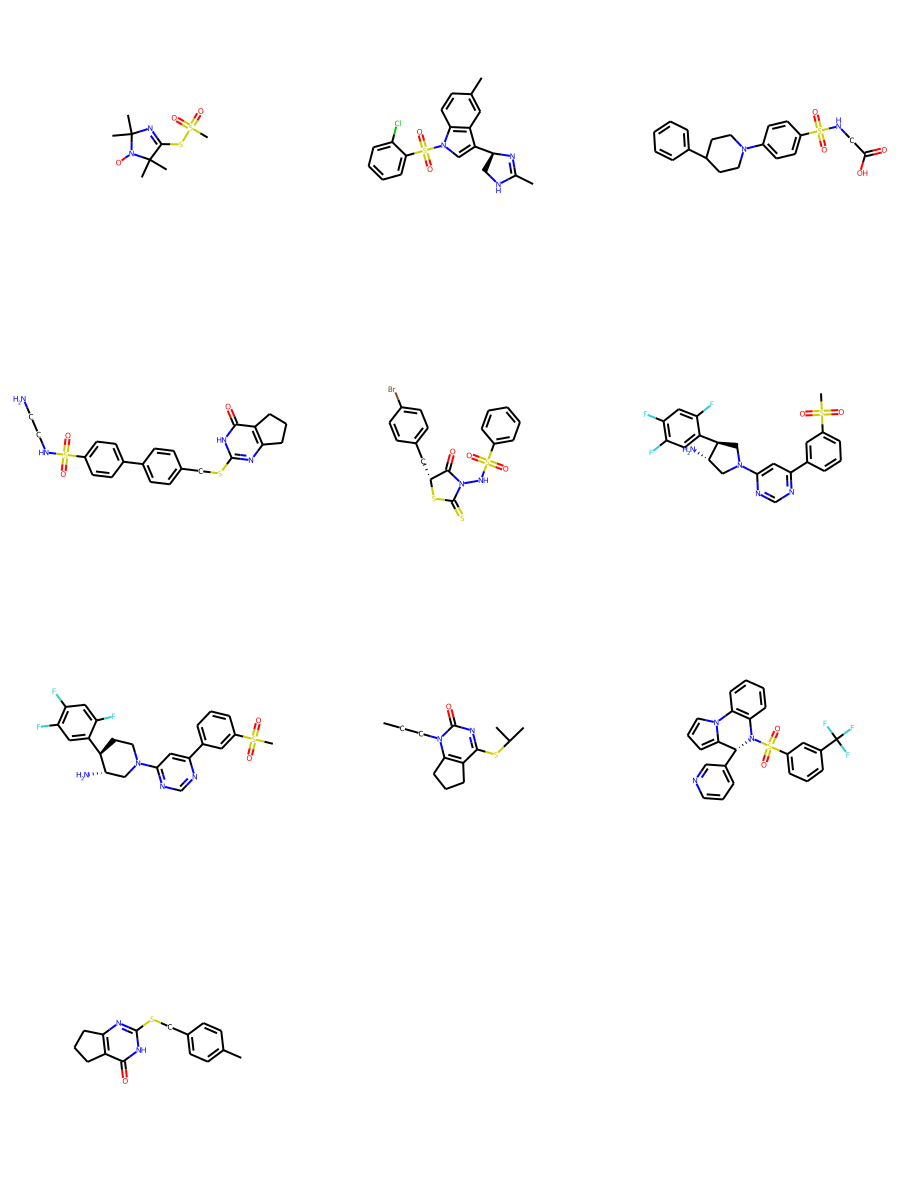

In [10]:
display(nbrs)

# Bonds

In [3]:
# Fragment on bonds
fragmenter = BondFragmenter(exclude_elements=["H"])
fragments = fragmenter(containers)

In [4]:
%%time
# Featurize the fragments
featurizer = MorganFeaturizer(nBits=1024)
features = featurizer.featurize(fragments,nproc=32)

  0%|          | 0/396400 [00:00<?, ?it/s]

CPU times: user 17.3 s, sys: 3.85 s, total: 21.1 s
Wall time: 45 s


In [5]:
%%time
# label the fragments
labeler = BondFragmentLabeler()
labels = labeler(fragments)

  0%|          | 0/396400 [00:00<?, ?it/s]

CPU times: user 13.9 s, sys: 1.18 s, total: 15 s
Wall time: 31 s


In [6]:
# train/test split
from sklearn.model_selection import train_test_split
inds = np.arange(len(fragments))
train,test = train_test_split(inds,test_size=0.2)
feat_train, feat_test = features[train], features[test]
labels_train, labels_test = labels[train], labels[test]
frags_train = [fragments[i] for i in train]
frags_test = [fragments[i] for i in test]

## kNN

In [7]:
%%time
knn = FragmentKNN(frags_train,feat_train)

CPU times: user 44min 22s, sys: 3min 6s, total: 47min 28s
Wall time: 3min


In [8]:
%%time
nbr_frags,inds = knn.query(feat_test,k=100,return_ind=True)

CPU times: user 35.5 s, sys: 117 ms, total: 35.6 s
Wall time: 35.5 s


In [9]:
nbr_labels = labels_train[inds]

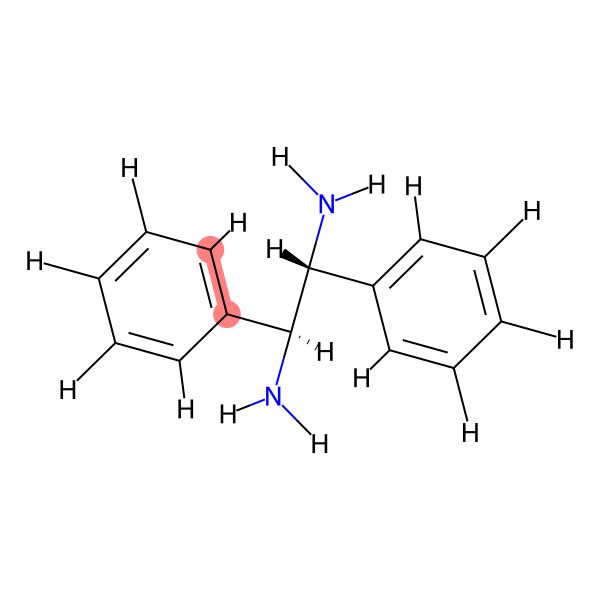

In [10]:
display(frags_test[1])

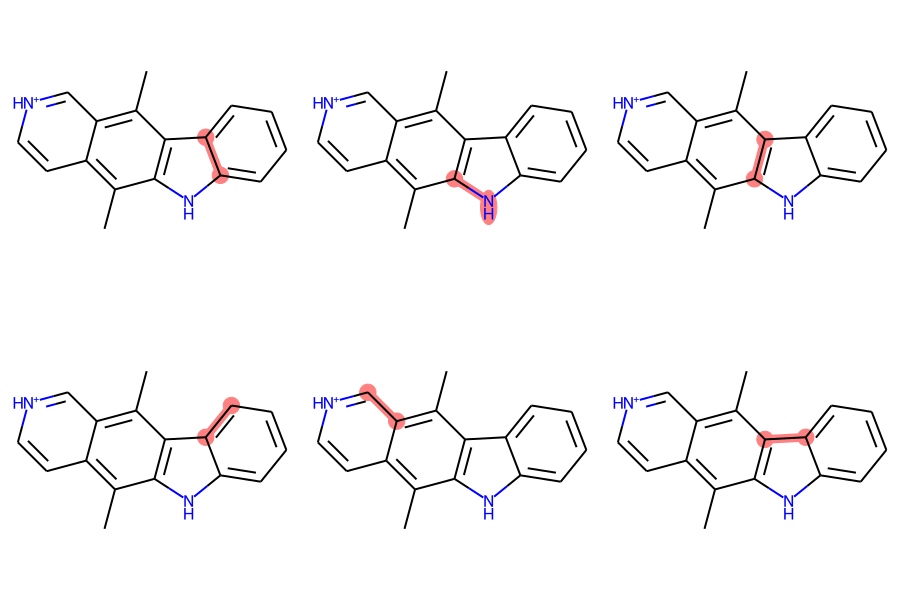

In [11]:
display(nbr_frags[0])

In [17]:
import seaborn as sns

<AxesSubplot:ylabel='Count'>

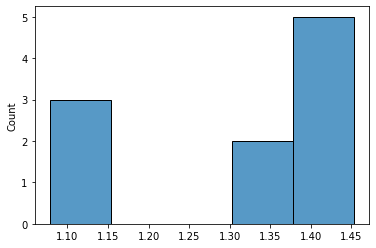

In [19]:
sns.histplot(nbr_labels[0][:10])

## MLP Regression

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor


In [18]:
model = MLPRegressor(hidden_layer_sizes=(512,128))

In [ ]:
%%time
_ = model.fit(X_train,y_train)

In [ ]:
modelnn = 

# Angles

In [ ]:
# Fragment on angles
fragmenter = AngleFragmenter(exclude_elements=["H"])
fragments = fragmenter(containers)

In [ ]:
%%time
# Featurize the fragments
featurizer = MorganFeaturizer(nBits=1024)
features = featurizer.featurize(fragments,nproc=32)

In [ ]:
# label the fragments
labeler = AngleFragmentLabeler()
labels = labeler(fragments)

## kNN

## MLP Regression